In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

plt.style.use('ggplot')
sns.set_style(rc=plt.rcParams)

from src.parameters import ANIMALS
from loren_frank_data_processing import make_epochs_dataframe
from loren_frank_data_processing import make_neuron_dataframe
from loren_frank_data_processing import get_position_dataframe
from loren_frank_data_processing import get_spikes_dataframe

epoch_info = make_epochs_dataframe(ANIMALS)

epoch_key = ('HPa', 3, 2) # animal, day, epoch
position_info = get_position_dataframe(epoch_key, ANIMALS)

Failed to load file: /home/trevortknguyen/repos/tn_decoding/src/../Raw-Data/HPa_direct/HPaDIO03.mat
No DIO file found, using distance from well to segment trials
Failed to load file: /home/trevortknguyen/repos/tn_decoding/src/../Raw-Data/HPa_direct/HPaDIO03.mat
No DIO file found, inferring correct inbound/outbound from task rules


In [3]:
position_info['time_sec'] = position_info.index / np.timedelta64(1, 's')

In [4]:
neuron_info = make_neuron_dataframe(ANIMALS)
neuron_info = neuron_info.xs(epoch_key, drop_level=False)

In [5]:
position_info

,x_position,y_position,head_direction,speed,linear_distance,projected_x_position,projected_y_position,track_segment_id,arm_name,labeled_segments,from_well,to_well,task,is_correct,turn,linear_position,linear_velocity,linear_speed,time_sec
time,,,,,,,,,,,,,,,,,,,
0 days 00:44:27.394800,99.016856,60.484488,NaN,13.201583,38.311049,98.071994,60.467253,0.0,Center Arm,1,NaN,NaN,NaN,False,NaN,38.311049,0.794794,0.794794,2667.3948
0 days 00:44:27.428100,98.331665,59.897514,NaN,13.201583,38.885429,98.082470,59.892968,0.0,Center Arm,1,NaN,NaN,NaN,False,NaN,38.885429,0.794794,0.794794,2667.4281
0 days 00:44:27.461500,97.668233,59.378460,NaN,13.216356,39.392298,98.091714,59.386184,0.0,Center Arm,1,NaN,NaN,NaN,False,NaN,39.392298,1.589229,1.589229,2667.4615
0 days 00:44:27.494800,97.260545,58.823229,NaN,13.246184,39.940000,98.101703,58.838573,0.0,Center Arm,1,NaN,NaN,NaN,False,NaN,39.940000,2.382901,2.382901,2667.4948
0 days 00:44:27.528200,97.007111,58.252922,-1.383185,13.291614,40.505590,98.112018,58.273077,0.0,Center Arm,1,NaN,NaN,NaN,False,NaN,40.505590,3.175396,3.175396,2667.5282
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0 days 01:05:41.852800,103.350000,99.436466,NaN,0.103949,0.000000,97.373272,98.771930,0.0,Center Arm,138,NaN,NaN,NaN,False,NaN,0.000000,0.000000,0.000000,3941.8528
0 days 01:05:41.886100,103.350000,99.485082,NaN,0.107592,0.000000,97.373272,98.771930,0.0,Center Arm,138,NaN,NaN,NaN,False,NaN,0.000000,0.000000,0.000000,3941.8861
0 days 01:05:41.919500,103.350000,99.538789,0.352990,0.110385,0.000000,97.373272,98.771930,0.0,Center Arm,138,NaN,NaN,NaN,False,NaN,0.000000,0.000000,0.000000,3941.9195


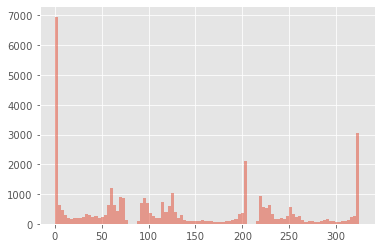

In [10]:
plt.hist(position_info['linear_position'], bins=100, alpha=0.5)
plt.show()
None

In [17]:
## try to bin it
position_info['linear_position_binned'] = position_info['linear_position'] // 2

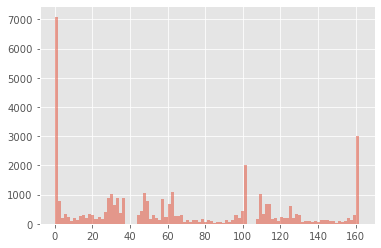

In [12]:
plt.hist(position_info['linear_position_binned'], bins=100, alpha=0.5)
None

In [14]:
def get_position_info_indices_at_spikes(spike_times_sec, position_info):
    '''
    spike_times_sec must be the times in seconds
    position_info must be modified to have a 'time_sec' column with corresponding units to spike_times_sec
    '''
    time_indices = np.empty((spike_times_sec.shape[0]), dtype='int')

    spike_time_index = 0

    for i, spike_time in enumerate(spike_times_sec):
        for index in range(spike_time_index, position_info['time_sec'].shape[0]):
            prev_index = max(0, index-1)
            prev_pos_time = position_info['time_sec'][prev_index]
            pos_time = position_info['time_sec'][index]
            # if we have gone too far
            if pos_time > spike_time:
                spike_time_index = prev_index
                break
        # time_ind (where to index into positions table)
        time_indices[i] = spike_time_index
    return time_indices

In [16]:
def get_combined_dataframe(neuron_info, position_info):
    '''
    Combines all spikes from different neurons with associated position information
    
    Does some copying.
    '''
    # this happens on single core
    df = pd.DataFrame()

    for neuron_idx in range(neuron_info.index.shape[0]):
        neuron_area = neuron_info.iloc[neuron_idx]['area']
        neuron_id = neuron_info.iloc[neuron_idx]['neuron_id']

        spike_times = get_spikes_dataframe(neuron_info.index[neuron_idx], ANIMALS)
        spike_times_sec = spike_times.index / np.timedelta64(1, 's')
        time_indices = get_position_info_indices_at_spikes(spike_times_sec, position_info)

        spike_position_info = position_info.iloc[time_indices].copy()
        spike_position_info['neuron_idx'] = neuron_idx
        spike_position_info['neuron_area'] = neuron_area
        spike_position_info['neuron_id'] = neuron_id
        
        # technically inaccurate, but helps with frequency
        spike_position_info['time_sec'] = spike_times_sec

        df = df.append(spike_position_info)
    return df


In [18]:
combined_info = get_combined_dataframe(neuron_info, position_info)

In [19]:
df = combined_info

In [22]:
df.columns

Index(['x_position', 'y_position', 'head_direction', 'speed',
       'linear_distance', 'projected_x_position', 'projected_y_position',
       'track_segment_id', 'arm_name', 'labeled_segments', 'from_well',
       'to_well', 'task', 'is_correct', 'turn', 'linear_position',
       'linear_velocity', 'linear_speed', 'time_sec', 'linear_position_binned',
       'neuron_idx', 'neuron_area', 'neuron_id'],
      dtype='object')

In [37]:
df = df[(df.neuron_area == 'CA1') & (df.neuron_id == 'HPa_03_02_001_001')]

In [83]:
class AdditiveHistogram():
    def __init__(self):
        self.hist = {}
    
    def add(self, key, increment):
        if key in self.hist.keys():
            self.hist[key] += increment
        else:
            self.hist[key] = increment
        
    def get(self, key):
        if key in self.hist.keys():
            return self.hist[key]
        else:
            return 0
        
    def values(self):
        return np.array([x for x in self.hist.keys()]), np.array([x for x in self.hist.values()])

In [87]:
occupancy = AdditiveHistogram()

for i, e in enumerate(position_info['linear_position_binned']):
    occupancy.add(e, 0.033399999999801366)

In [85]:
occupancy_bins, occupancy_secs = occupancy.values()

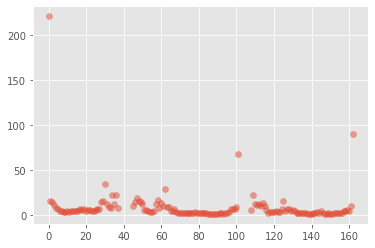

In [94]:
plt.scatter(occupancy_bins, occupancy_secs, alpha=0.5)

In [88]:
spikes = AdditiveHistogram()

for i, e in enumerate(df['linear_position_binned']):
    spikes.add(e, 1)

In [89]:
spikes_bins, spikes_counts = spikes.values()

In [92]:
spikes_frequencies = np.array([scount / occupancy.get(sbin) for (sbin, scount) in zip(spikes_bins, spikes_counts)])

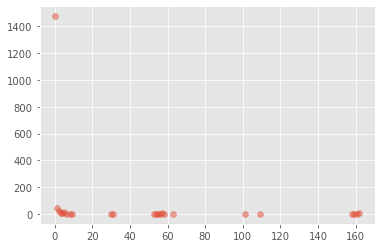

In [93]:
plt.scatter(spikes_bins, spikes_counts, alpha=0.5)

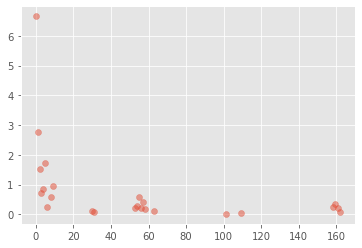

In [96]:
plt.scatter(spikes_bins, spikes_frequencies, alpha=0.5)

In [97]:
df = combined_info
neuron_ids_ca1 = df[df.neuron_area == 'CA1']['neuron_id'].unique()

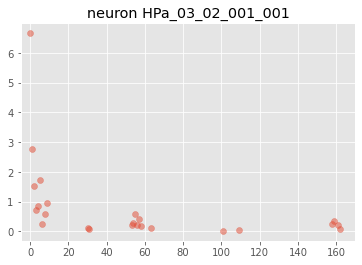

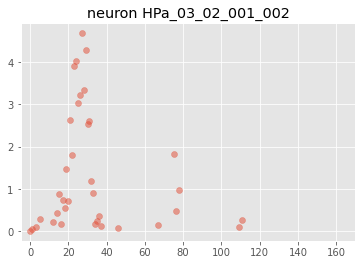

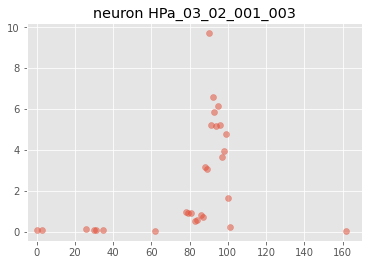

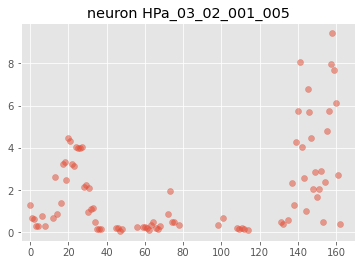

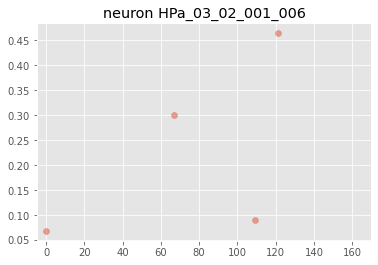

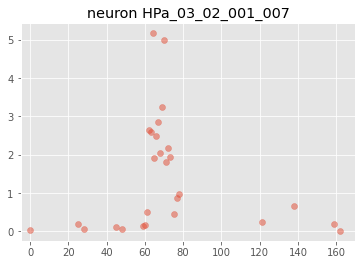

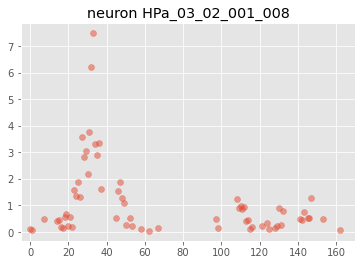

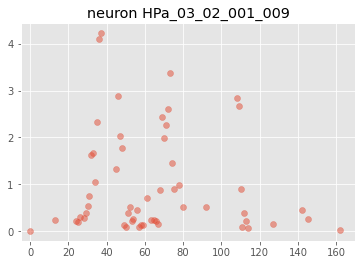

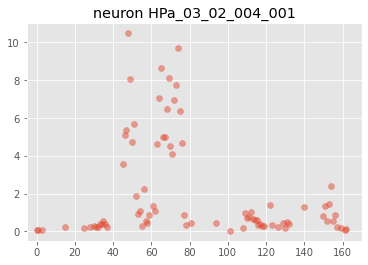

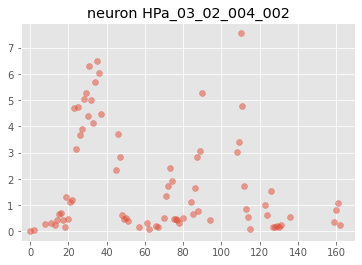

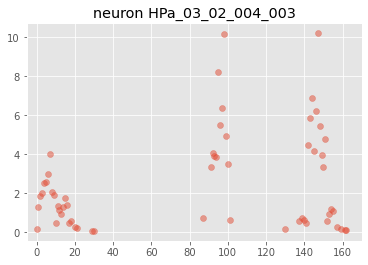

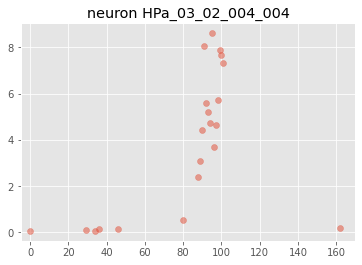

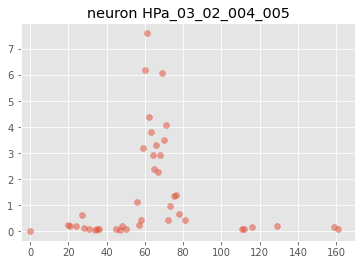

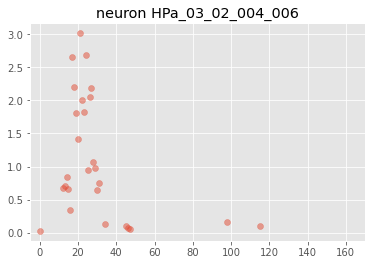

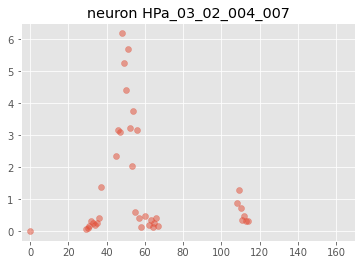

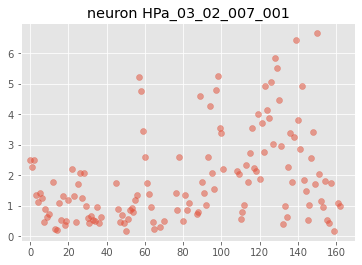

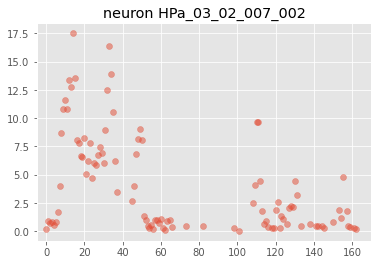

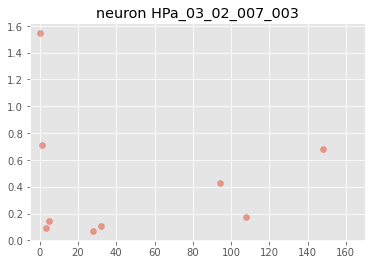

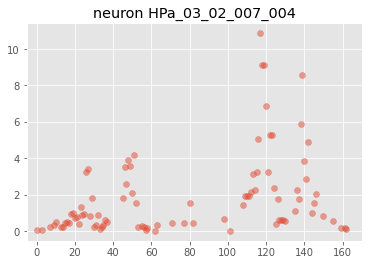

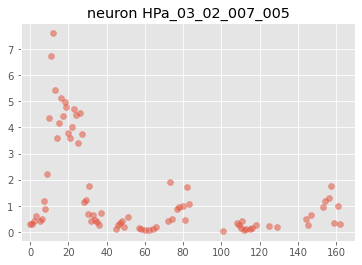

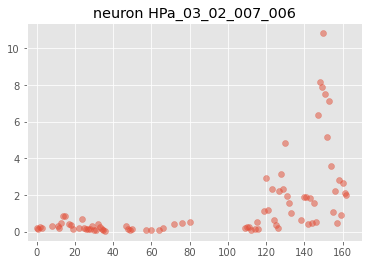

In [104]:
for neuron_id in neuron_ids_ca1:
    df_neuron = df[df.neuron_id == neuron_id]
    
    spikes = AdditiveHistogram()
    for i, e in enumerate(df_neuron['linear_position_binned']):
        spikes.add(e, 1)
    spikes_bins, spikes_counts = spikes.values()
    spikes_frequencies = np.array([scount / occupancy.get(sbin) for (sbin, scount) in zip(spikes_bins, spikes_counts)])
    plt.scatter(spikes_bins, spikes_frequencies, alpha=0.5)
    plt.title("neuron {0}".format(neuron_id))
    
    plt.xlim(-5, 170)
    plt.show()